# [실험A] 손실 함수 비교 : CrossEntropy Loss vs MSE Loss (with softmax)

##### - MSE와 CrossEntropy가 학습 성능에 미치는 차이 분석
##### - 학습 곡선의 수렴 속도, 정확도, loss 안정성 비교

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons, make_circles, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np



In [3]:
# RTX 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
epochs = 10
lr = 0.001




▶ Running experiment: CrossEntropy Loss
[CrossEntropy Loss] Epoch 1 | Train Loss: 0.5665 | Test Acc: 0.8395
[CrossEntropy Loss] Epoch 2 | Train Loss: 0.3994 | Test Acc: 0.8563
[CrossEntropy Loss] Epoch 3 | Train Loss: 0.3537 | Test Acc: 0.8633
[CrossEntropy Loss] Epoch 4 | Train Loss: 0.3271 | Test Acc: 0.8707
[CrossEntropy Loss] Epoch 5 | Train Loss: 0.3067 | Test Acc: 0.8692
[CrossEntropy Loss] Epoch 6 | Train Loss: 0.2920 | Test Acc: 0.8744
[CrossEntropy Loss] Epoch 7 | Train Loss: 0.2791 | Test Acc: 0.8762
[CrossEntropy Loss] Epoch 8 | Train Loss: 0.2674 | Test Acc: 0.8802
[CrossEntropy Loss] Epoch 9 | Train Loss: 0.2569 | Test Acc: 0.8717
[CrossEntropy Loss] Epoch 10 | Train Loss: 0.2477 | Test Acc: 0.8823

▶ Running experiment: MSE Loss with Softmax
[MSE Loss with Softmax] Epoch 1 | Train Loss: 0.0284 | Test Acc: 0.8377
[MSE Loss with Softmax] Epoch 2 | Train Loss: 0.0209 | Test Acc: 0.8439
[MSE Loss with Softmax] Epoch 3 | Train Loss: 0.0190 | Test Acc: 0.8609
[MSE Loss with So

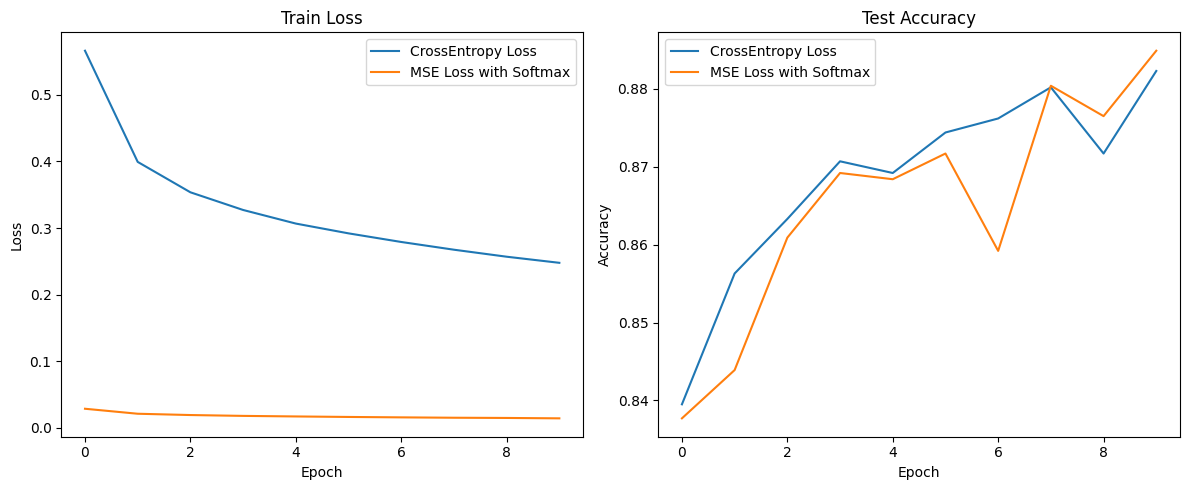

In [7]:

# 데이터 로딩
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 훈련 함수
def train(model, loss_fn, optimizer, use_softmax=False):
    model.train()
    total_loss, correct = 0, 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if use_softmax:
            output = F.softmax(output, dim=1)
            target_onehot = F.one_hot(target, num_classes=10).float()
            loss = loss_fn(output, target_onehot)
        else:
            loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = correct / len(train_loader.dataset)
    return avg_loss, accuracy

# 테스트 함수
def evaluate(model, loss_fn, use_softmax=False):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if use_softmax:
                output = F.softmax(output, dim=1)
                target_onehot = F.one_hot(target, num_classes=10).float()
                loss = loss_fn(output, target_onehot)
            else:
                loss = loss_fn(output, target)
            total_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    avg_loss = total_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    return avg_loss, accuracy

# 실험 실행 함수
def run_experiment(loss_fn, use_softmax=False, label=""):
    model = MLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_accs = [], []

    print(f"\n▶ Running experiment: {label}")
    for epoch in range(epochs):
        train_loss, train_acc = train(model, loss_fn, optimizer, use_softmax)
        test_loss, test_acc = evaluate(model, loss_fn, use_softmax)
        print(f"[{label}] Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f}")
        train_losses.append(train_loss)
        test_accs.append(test_acc)
    return train_losses, test_accs

# 실험 실행
ce_losses, ce_accs = run_experiment(nn.CrossEntropyLoss(), use_softmax=False, label="CrossEntropy Loss")
mse_losses, mse_accs = run_experiment(nn.MSELoss(), use_softmax=True, label="MSE Loss with Softmax")

# 결과 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ce_losses, label="CrossEntropy Loss")
plt.plot(mse_losses, label="MSE Loss with Softmax")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ce_accs, label="CrossEntropy Loss")
plt.plot(mse_accs, label="MSE Loss with Softmax")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
def load_dataset(dataset_name='fashion'):
    if dataset_name == 'fashion':
        transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
        train = datasets.FashionMNIST(root='data', train=True, transform=transform, download=True)
        test = datasets.FashionMNIST(root='data', train=False, transform=transform, download=True)
        input_size = 28 * 28
        num_classes = 10
        return DataLoader(train, batch_size=64, shuffle=True), DataLoader(test, batch_size=64), input_size, num_classes

    elif dataset_name == 'digits':
        digits = load_digits()
        X = StandardScaler().fit_transform(digits.data)
        y = digits.target
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
        test = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test))
        return DataLoader(train, batch_size=64, shuffle=True), DataLoader(test, batch_size=64), X.shape[1], 10


In [5]:
def load_toy_dataset(type='moons'):
    if type == 'moons':
        X, y = make_moons(n_samples=2000, noise=0.2, random_state=42)
    elif type == 'circles':
        X, y = make_circles(n_samples=2000, noise=0.1, factor=0.5, random_state=42)

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    train = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
    test = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test))
    return DataLoader(train, batch_size=64, shuffle=True), DataLoader(test, batch_size=64), 2, 2


In [6]:
def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, epochs=20, device='cpu'):
    model.to(device)
    train_losses, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                preds = outputs.argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        acc = correct / total
        test_accuracies.append(acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Test Acc: {acc:.4f}")

    return train_losses, test_accuracies


# 범용 코드

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# 실험 설정
experiment_type = 'B'         # 'A', 'B', 'C' 중 선택
loss_choice = 'cross_entropy' # 'cross_entropy' 또는 'mse'
act_func_name = 'relu'        # 'relu', 'leaky_relu', 'sigmoid'
optimizer = 'adam'     # 'sgd', 'momentum', 'adam'

lr = 0.001 if optimizer == 'adam' else 0.01
num_epochs = 60

Epoch 1/60 | Loss: 0.5183 | Test Acc: 0.8567
Epoch 2/60 | Loss: 0.3180 | Test Acc: 0.8900
Epoch 3/60 | Loss: 0.2705 | Test Acc: 0.9000
Epoch 4/60 | Loss: 0.2445 | Test Acc: 0.9200
Epoch 5/60 | Loss: 0.2317 | Test Acc: 0.9300
Epoch 6/60 | Loss: 0.2179 | Test Acc: 0.9367
Epoch 7/60 | Loss: 0.2046 | Test Acc: 0.9400
Epoch 8/60 | Loss: 0.1932 | Test Acc: 0.9433
Epoch 9/60 | Loss: 0.1833 | Test Acc: 0.9533
Epoch 10/60 | Loss: 0.1753 | Test Acc: 0.9533
Epoch 11/60 | Loss: 0.1667 | Test Acc: 0.9567
Epoch 12/60 | Loss: 0.1602 | Test Acc: 0.9600
Epoch 13/60 | Loss: 0.1547 | Test Acc: 0.9633
Epoch 14/60 | Loss: 0.1508 | Test Acc: 0.9633
Epoch 15/60 | Loss: 0.1462 | Test Acc: 0.9633
Epoch 16/60 | Loss: 0.1420 | Test Acc: 0.9633
Epoch 17/60 | Loss: 0.1389 | Test Acc: 0.9633
Epoch 18/60 | Loss: 0.1360 | Test Acc: 0.9633
Epoch 19/60 | Loss: 0.1340 | Test Acc: 0.9633
Epoch 20/60 | Loss: 0.1317 | Test Acc: 0.9633
Epoch 21/60 | Loss: 0.1299 | Test Acc: 0.9633
Epoch 22/60 | Loss: 0.1287 | Test Acc: 0.96

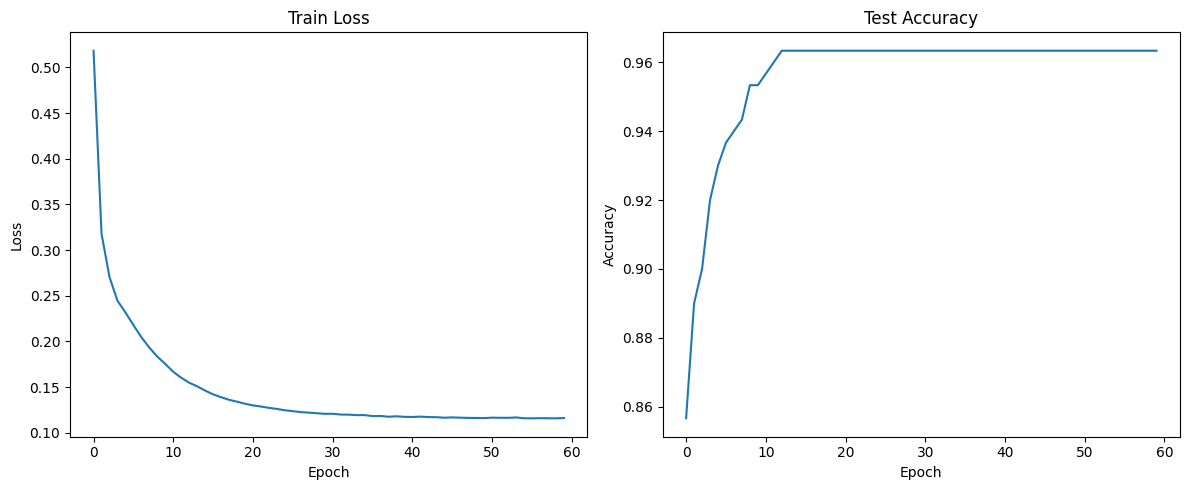

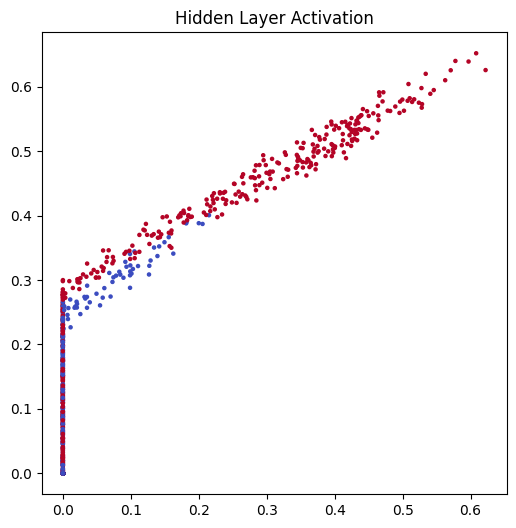

In [27]:


# 데이터 로드
def get_data(exp_type):
    if exp_type in ['A', 'C']:# 실험A,B (FashionMNIST)
        to_tensor = transforms.ToTensor()
        train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=to_tensor)
        test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=to_tensor)
        input_dim = 28 * 28
        num_classes = 10
        train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
        test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    else:  # 실험 B (make_moons)
        x, y = make_moons(n_samples=1000, noise=0.2)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
        train_loader = DataLoader(TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                                                torch.tensor(y_train, dtype=torch.long)), batch_size=64, shuffle=True)
        test_loader = DataLoader(TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                                               torch.tensor(y_test, dtype=torch.long)), batch_size=64, shuffle=False)
        input_dim = 2
        num_classes = 2
    return train_loader, test_loader, input_dim, num_classes

train_loader, test_loader, input_dim, num_classes = get_data(experiment_type)

# -------------------- 활성화 함수 선택 --------------------
def get_act_func(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    elif name == 'sigmoid':
        return nn.Sigmoid()

# -------------------- MLP 모델 정의 --------------------
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, num_classes, act_name):
        super().__init__()
        act = get_act_func(act_name)
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            act,
            nn.Linear(256, 128),
            act,
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

model = SimpleMLP(input_dim, num_classes, act_func_name)

# -------------------- 손실 함수 및 옵티마이저 --------------------
if loss_choice == 'cross_entropy':
    loss_fn = nn.CrossEntropyLoss()
elif loss_choice == 'mse':
    loss_fn = nn.MSELoss()

if optimizer == 'sgd':
    opt = optim.SGD(model.parameters(), lr=lr)
elif optimizer == 'momentum':
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
elif optimizer == 'adam':
    opt = optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)

# -------------------- 학습 루프 --------------------
train_loss_list = []
test_acc_list = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.view(x_batch.size(0), -1) if experiment_type != 'B' else x_batch
        preds = model(x_batch)

        if loss_choice == 'mse':
            one_hot = torch.zeros_like(preds)
            one_hot.scatter_(1, y_batch.unsqueeze(1), 1)
            loss = loss_fn(torch.softmax(preds, dim=1), one_hot)
        else:
            loss = loss_fn(preds, y_batch)

        opt.zero_grad()
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    
    scheduler.step()
    train_loss_list.append(epoch_loss / len(train_loader))

    # 평가
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.view(x_batch.size(0), -1) if experiment_type != 'B' else x_batch
            output = model(x_batch)
            pred_label = torch.argmax(output, dim=1)
            correct += (pred_label == y_batch).sum().item()
            total += y_batch.size(0)
    
    acc = correct / total
    test_acc_list.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss_list[-1]:.4f} | Test Acc: {acc:.4f}")

# -------------------- 시각화 --------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_acc_list)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# -------------------- 실험 B 시 시각화 --------------------
if experiment_type == 'B':
    def draw_hidden(model, x_data):
        with torch.no_grad():
            x_tensor = torch.tensor(x_data, dtype=torch.float32)
            h = model.layers[0](x_tensor)
            h = get_act_func(act_func_name)(h)
            h = h.numpy()
            plt.figure(figsize=(6, 6))
            plt.scatter(h[:, 0], h[:, 1], c=y, cmap='coolwarm', s=5)
            plt.title('Hidden Layer Activation')
            plt.show()

    x, y = make_moons(n_samples=1000, noise=0.2)
    draw_hidden(model, x)


In [ ]:
# 실험 설정
experiment_type = 'B'         # 'A', 'B', 'C' 중 선택
loss_choice = 'cross_entropy' # 'cross_entropy' 또는 'mse'
act_func_name = 'leaky_relu'        # 'relu', 'leaky_relu', 'sigmoid'
optimizer = 'adam'     # 'sgd', 'momentum', 'adam'

lr = 0.001 if optimizer == 'adam' else 0.01
num_epochs = 60